# Import Data

In [138]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.optim as optimr

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE

In [139]:
zip_path = "ALLFLOWMETER_HIKARI2021.zip"

with zipfile.ZipFile(zip_path, 'r') as zipped_file:
    csv_file_name = zipped_file.namelist()[0]

    with zipped_file.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file)

In [140]:
df.head()

,Unnamed: 0.1,Unnamed: 0,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,0,0,Cg61Jch3vdz9DBptj,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,1
1,1,1,CdRIlqLWdj35Y9vW9,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,...,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,1
2,2,2,CLzp9Khd0Y09Qkgrg,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,...,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,1
3,3,3,Cnf1YA4iLB4CSNWB88,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,...,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,1
4,4,4,C4ZKvv3fpO72EAOsJ6,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,...,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0,Bruteforce-XML,1


# Data Preprocessing

## Feature Selection

In [141]:
drop_label = ['Unnamed: 0.1', 'Unnamed: 0', 'uid', 'Label']
df = df.drop(labels=drop_label, axis=1)
df.head()

,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category
0,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,6,6,6.794746,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML
1,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,6,6,0.960045,...,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML
2,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,6,5,1.147225,...,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML
3,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,6,5,1.401058,...,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML
4,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,6,5,1.799345,...,126016.885411,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0,Bruteforce-XML


In [142]:
df['traffic_category'].unique()

array(['Bruteforce-XML', 'Bruteforce', 'Background', 'Benign', 'Probing',
       'XMRIGCC CryptoMiner'], dtype=object)

In [143]:
numerical_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()

## Encoding

One-hot untuk target, fitur lain menggunakan label encoding

In [144]:
encoder_label = LabelEncoder()

for col in categorical_features:
    df[col] = encoder_label.fit_transform(df[col])


## Z-Score Standarization

In [145]:
zscore = StandardScaler()

def Standarization(df):
    df_zscore = zscore.fit_transform(df)
    df = pd.DataFrame(df_zscore, columns=df.columns)
    return df

## MinMax Normalization

In [146]:
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [147]:
df['traffic_category'].nunique()


6

# Model

In [148]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, data_dim):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, data_dim),
            nn.Sigmoid()
        )

    def forward(self, noise, labels):
        label_input = self.label_embedding(labels)
        gen_input = torch.cat((noise, label_input), dim=1)
        return self.model(gen_input)


In [149]:
class Discriminator(nn.Module):
    def __init__(self, data_dim, num_classes):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, data_dim)
        self.model = nn.Sequential(
            nn.Linear(data_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, data, labels):
        label_input = self.label_embedding(labels)
        disc_input = torch.cat((data, label_input), dim=1)
        return self.model(disc_input)


In [150]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_g_loss = None
        self.best_d_loss = None
        self.counter = 0

    def step(self, g_loss, d_loss):
        if (self.best_g_loss is None or g_loss < self.best_g_loss - self.min_delta) and \
           (self.best_d_loss is None or d_loss < self.best_d_loss - self.min_delta):
            self.best_g_loss = g_loss
            self.best_d_loss = d_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

## Training

In [151]:
# Pisahkan fitur dan label
X = df.drop(columns=['traffic_category'])  # Fitur
y = df['traffic_category']  # Label

# Konversi DataFrame ke numpy array
X = X.to_numpy()
y = y.to_numpy()

In [152]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [153]:
data = torch.tensor(X, dtype=torch.float32)
labels = torch.tensor(y, dtype=torch.long)
data, labels = data.to(device), labels.to(device)

In [154]:
# Parameter
latent_dim = 10  # Dimensi noise
data_dim = X.shape[1]
num_classes = len(torch.unique(labels))
batch_size = 64
epochs = 10000

# Model
generator = Generator(latent_dim, num_classes, data_dim).to(device)
discriminator = Discriminator(data_dim, num_classes).to(device)

# Optimizer dan Loss
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
adversarial_loss = nn.BCELoss().to(device)


Epoch 0 | D Loss: 9.267769928225644e-13| G Loss: 27.116641998291016
Early stopping at epoch 10 dengan D Loss: 2.2017569787768226e-13| G Loss: 28.505910873413086


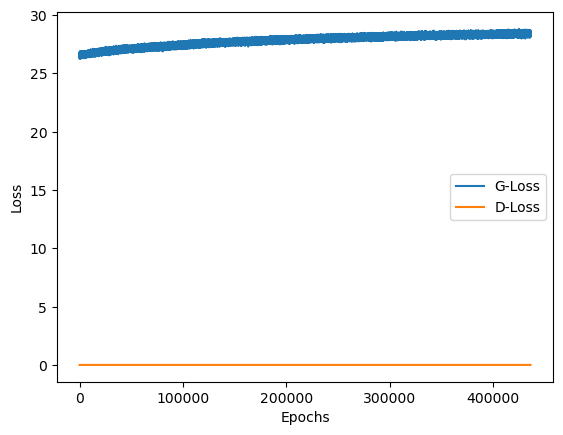

In [156]:
from torch.utils.data import DataLoader, TensorDataset

# DataLoader
dataset = TensorDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Pelatihan
early_stopping = EarlyStopping(patience=10)

g_losses = []
d_losses = []

for epoch in range(epochs):
    for real_data, real_labels in dataloader:
        real_data, real_labels = real_data.to(device), real_labels.to(device)
        batch_size = real_data.size(0)

        # Label untuk diskriminator
        valid = torch.ones((batch_size, 1), requires_grad=False).to(device)
        fake = torch.zeros((batch_size, 1), requires_grad=False).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        noise = torch.randn(batch_size, latent_dim).to(device)
        sampled_labels = torch.randint(0, num_classes, (batch_size,)).to(device)

        # Data palsu dari generator
        generated_data = generator(noise, sampled_labels)

        # Loss untuk data asli dan palsu
        real_loss = adversarial_loss(discriminator(real_data, real_labels), valid)
        fake_loss = adversarial_loss(discriminator(generated_data.detach(), sampled_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        # Backpropagation Discriminator
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        noise = torch.randn(batch_size, latent_dim).to(device)
        sampled_labels = torch.randint(0, num_classes, (batch_size,)).to(device)

        # Generator mencoba menipu discriminator
        g_loss = adversarial_loss(discriminator(generator(noise, sampled_labels), sampled_labels), valid)

        # Backpropagation Generator
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Simpan loss
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    # Cek kondisi Early Stopping
    if early_stopping.step(g_loss.item(), d_loss.item()):
        print(f"Early stopping at epoch {epoch} dengan D Loss: {d_loss.item()}| G Loss: {g_loss.item()}")
        break

    # Cetak metrik pelatihan setiap 100 epoch
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item()}| G Loss: {g_loss.item()}")

# Plot loss
plt.plot(range(len(g_losses)), g_losses, label='G-Loss')
plt.plot(range(len(d_losses)), d_losses, label='D-Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()